In [1]:
from nmf import *
from utils import *
import numpy as np
from projection import project_onto_Sigma
from data_generation import generate_separable_data

In [17]:
# Main algorithm: Kernel Separable NMF
# ToDo: integrate in NMF class in nmf.py
import numpy as np

def mean_groups_diff(X):
    """
    Compute the difference between the means of the two groups of diagonal norms
    of the matrix X, where the groups are defined by a gap in the sorted diagonal norms.
    
    Parameters:
        X : np.ndarray
            Input matrix (typically the output of a kernel NMF).
    
    Returns:
        diff : float
            The difference between the means of the two groups.
    """
    # Sort the diagonal elements in descending order
    diag_X = np.diag(X)
    sorted_diag = np.sort(diag_X)[::-1]  # Descending order

    # Compute consecutive differences
    diffs = sorted_diag[:-1] - sorted_diag[1:]

    # Find the index of the largest gap
    gap_index = np.argmax(diffs)

    # Split into two groups based on the gap index
    large_group = sorted_diag[:gap_index+1]
    small_group = sorted_diag[gap_index+1:]

    # Calculate means and their difference
    mean_large = np.mean(large_group)
    mean_small = np.mean(small_group)

    return mean_large - mean_small

def group_gap(X):
    """
    Compute the gap between the two groups of diagonal norms of the matrix X,
    where the groups are defined by a gap in the sorted diagonal norms.
    Parameters:
        X : np.ndarray
            Input matrix (typically the output of a kernel NMF).
    Returns:    
        gap : float
            The gap between the means of the two groups.
            """
    # Sort the diagonal elements in descending order
    diag_X = np.diag(X)
    sorted_diag = np.sort(diag_X)[::-1]  # Descending order

    # Compute consecutive differences
    diffs = sorted_diag[:-1] - sorted_diag[1:]

    # Find the index of the largest gap
    gap = np.max(diffs)

    return gap

def kernel_separable_nmf(K, lambda_param=1.0, max_iter=100, r=3, verbose=False, tol=1e-3, gap_tolerance=None):
    """
    Kernel Separable NMF algorithm with convergence tolerance.

    Parameters:
        K            : Kernel matrix (typically M^T M).
        lambda_param : Regularization parameter.
        max_iter     : Maximum number of iterations.
        r            : Number of columns (indices) to select (expected anchors).
        verbose      : If True, prints progress.
        tol          : Convergence threshold for diagonal updates.

    Returns:
        X         : The final matrix X after updates.
        indices   : The indices corresponding to the r largest diagonal entries of X.
        diag_norms: List of diagonal vectors (one per iteration) for analysis.
    """
    n = K.shape[0]
    X = np.random.rand(n, n)
    I = np.eye(n)
    epsilon = 1e-10
    diag_norms = []
    mean_groups_diffs = []  # To store the mean differences for analysis

    # For checking convergence
    prev_diag = None  # Will store the diagonal of X at the previous iteration
    
    for it in range(max_iter):
        KX = K @ X
        denom = 2 * lambda_param * KX + epsilon
        numerator = 2 * lambda_param * K - I
        
        update_factor = numerator / denom
        X = X * update_factor
        
        print(1, np.trace(X)+lambda_param*np.linalg.norm(M-M@X))
        X = project_onto_Sigma(X)  
        print(2, np.trace(X)+lambda_param*np.linalg.norm(M-M@X))
        X_diagonal = np.diag(X)
        diag_norms.append(X_diagonal)
        mean_groups_diffs.append(mean_groups_diff(X))
        # Convergence check: once we have a previous diagonal, compare norms
        if prev_diag is not None:
            diff = np.linalg.norm(X_diagonal - prev_diag)
            if diff < tol:
                if verbose:
                    print(f"Converged at iteration {it} with diagonal diff={diff:.6e}")
                break
        
        if gap_tolerance is not None:
            gap = group_gap(X)
            if gap > gap_tolerance:
                if verbose:
                    print(f"Converged at iteration {it} with gap={gap:.6e}")
                break
        
        prev_diag = X_diagonal
        
        # Optional progress logging
        if verbose and (it % 10 == 0 or it == max_iter - 1):
            diag_norm = np.linalg.norm(X_diagonal)
            print(f"Iteration {it}: ||diag(X)|| = {diag_norm:.4f}")
            print(f"iteration {it}: {np.trace(X)+lambda_param*np.linalg.norm(M-M@X):.4f} (objective value)")
    
    # After stopping (due to convergence or hitting max_iter),
    # pick the top r diagonal entries as "selected variables"
    final_diag = np.diag(X)  # or X_diagonal if you trust the break didn't skip an update
    indices = np.argsort(final_diag)[-r:][::-1]
    
    return X, indices, diag_norms, mean_groups_diffs


# ----- Example of usage -----
lambda_param = 50 # Higher value for lower sparsity on the diagonal of X
max_iter = 1000
n_anchors = 4

M, anchors_orig, H = generate_separable_data(n_anchors=n_anchors, n_samples=100, dimension=70, seed=2, kernel=None, sparsity_on_H=0)
K = np.dot(M.T, M)

X_kernel, selected_indices, diag_norms, mean_groups_diffs = kernel_separable_nmf(K, lambda_param, max_iter, n_anchors, verbose=True, gap_tolerance=0.4)

# ----- Print results -----
print("\nKernel matrix K:")
print(K)
print("\nFinal X matrix from Kernel Separable NMF:")
print(X_kernel)
print("\nIndices selected for factorization (should include the anchors):")
print(selected_indices)

1 363.4010879441874
2 1062.2468697253087
Iteration 0: ||diag(X)|| = 0.0916
iteration 0: 1062.2469 (objective value)
1 360.717608069971
2 360.8452730508479
1 356.8122866807529
2 356.9575314815354
1 352.87915627791944
2 353.01805502060364
1 348.88944130380634
2 349.0198656648108
1 344.8347968211543
2 344.95147557229285
1 340.7062647965387
2 340.82286900843275
1 336.5146462514394
2 336.62384776058315
1 332.25155439885145
2 332.35073127690197
1 327.9152861758892
2 328.00458247856204
1 323.5088078489489
2 323.58772642010223
Iteration 10: ||diag(X)|| = 0.3110
iteration 10: 323.5877 (objective value)
1 319.0369094269903
2 319.10697426812493
1 314.50827951148534
2 314.56928623544616
1 309.9322990046719
2 309.98477515139876
1 305.3205317782202
2 305.3651803635607
1 300.6858093985582
2 300.72427932215356
1 296.0422764391258
2 296.0753908879202
1 291.40310408898597
2 291.43134586255684
1 286.7806077820479
2 286.8043467284074
1 282.1861379896651
2 282.2247599305632
1 277.6485525525849
2 277.687739

In [11]:
X.shape

NameError: name 'X' is not defined

The algorithm selects the right anchors, so it works for the linear kernel

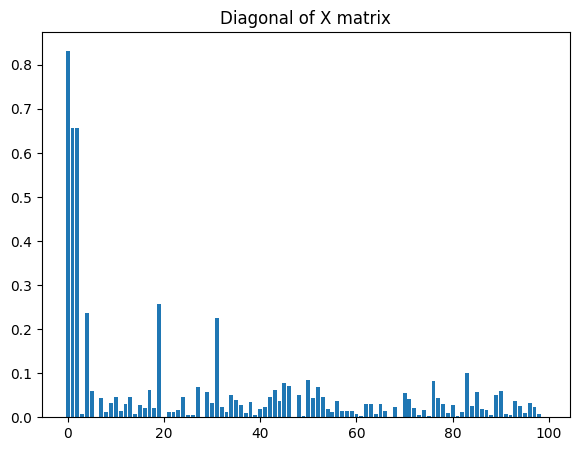

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
# bar plot of the diagonal of X
plt.subplot(1, 2, 1)
plt.bar(range(len(X_kernel)), np.diag(X_kernel))
plt.title("Diagonal of X matrix")
plt.show()

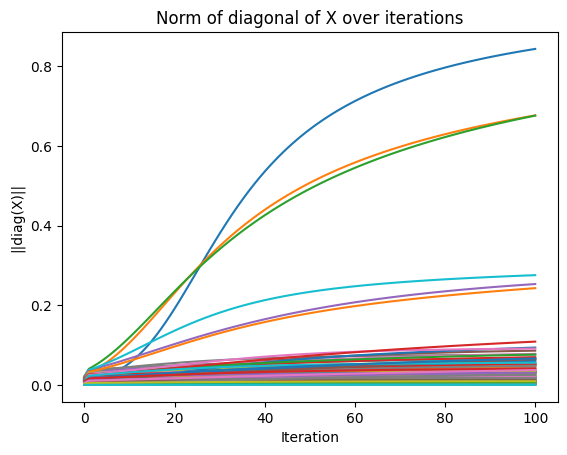

In [31]:
plt.plot(diag_norms)
plt.title("Norm of diagonal of X over iterations")
plt.xlabel("Iteration")
plt.ylabel("||diag(X)||")
plt.show()

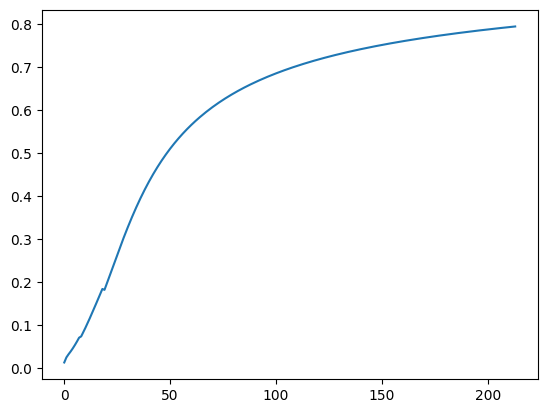

In [19]:
plt.plot(mean_groups_diffs)
plt.show()

In [24]:
# Sort the diagonal elements in descending order
diag_X = np.diag(X_kernel)
sorted_diag = np.sort(diag_X)[::-1]  # Descending order

# Compute consecutive differences
diffs = sorted_diag[:-1] - sorted_diag[1:]

# Find the index of the largest gap
gap = np.max(diffs)

gap

0.5040771342171912

In [22]:
sorted_diag[:-1]

array([9.23627990e-01, 7.97426022e-01, 7.71173187e-01, 2.67096053e-01,
       2.64115636e-01, 2.53487964e-01, 1.27262463e-01, 1.06178414e-01,
       8.46127111e-02, 8.02061842e-02, 8.01493041e-02, 7.98172143e-02,
       7.85375064e-02, 7.83813180e-02, 6.98979430e-02, 6.84213775e-02,
       6.63759281e-02, 6.41129188e-02, 6.03727937e-02, 5.99876232e-02,
       5.69226403e-02, 5.55744621e-02, 5.32272779e-02, 5.10597432e-02,
       4.90635021e-02, 4.90418990e-02, 4.88153413e-02, 4.88138025e-02,
       4.83864151e-02, 4.76116068e-02, 4.67273368e-02, 4.44696291e-02,
       4.26560301e-02, 3.84260458e-02, 3.68557210e-02, 3.64067037e-02,
       3.43472076e-02, 3.35443090e-02, 3.22562905e-02, 3.20434892e-02,
       3.19964734e-02, 3.15153546e-02, 3.03710018e-02, 2.98863628e-02,
       2.87551748e-02, 2.86041108e-02, 2.85628654e-02, 2.83391550e-02,
       2.81847163e-02, 2.55892807e-02, 2.50399580e-02, 2.45869413e-02,
       2.22654243e-02, 2.13658772e-02, 2.13116089e-02, 2.11519358e-02,
      

In [23]:
sorted_diag[1:]

array([7.97426022e-01, 7.71173187e-01, 2.67096053e-01, 2.64115636e-01,
       2.53487964e-01, 1.27262463e-01, 1.06178414e-01, 8.46127111e-02,
       8.02061842e-02, 8.01493041e-02, 7.98172143e-02, 7.85375064e-02,
       7.83813180e-02, 6.98979430e-02, 6.84213775e-02, 6.63759281e-02,
       6.41129188e-02, 6.03727937e-02, 5.99876232e-02, 5.69226403e-02,
       5.55744621e-02, 5.32272779e-02, 5.10597432e-02, 4.90635021e-02,
       4.90418990e-02, 4.88153413e-02, 4.88138025e-02, 4.83864151e-02,
       4.76116068e-02, 4.67273368e-02, 4.44696291e-02, 4.26560301e-02,
       3.84260458e-02, 3.68557210e-02, 3.64067037e-02, 3.43472076e-02,
       3.35443090e-02, 3.22562905e-02, 3.20434892e-02, 3.19964734e-02,
       3.15153546e-02, 3.03710018e-02, 2.98863628e-02, 2.87551748e-02,
       2.86041108e-02, 2.85628654e-02, 2.83391550e-02, 2.81847163e-02,
       2.55892807e-02, 2.50399580e-02, 2.45869413e-02, 2.22654243e-02,
       2.13658772e-02, 2.13116089e-02, 2.11519358e-02, 2.07172410e-02,
      

Here we would expect high values in correspondence of the anchors amd zeroes elsewhere.
Since we have 3 anchors in the position 0,1,2, it works